# “火炬上的深度学习"第一次大作业

在这个作业中，你需要半独立地利用人工神经网络搭建一个手写数字识别器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [27]:

"""简单的 LeNet-5类型的卷积神经网络模型，MNIST例子.
"""

#所有依赖包

import gzip
import os
import sys

import numpy as np
from six.moves import urllib
import torch
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pylab as plt

#定义一系列常数
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/' #图像数据如果没下载，可以从这个地址下载
WORK_DIRECTORY = 'data' #存储的路径名
IMAGE_SIZE = 28 #每张图片的大小尺寸
NUM_CHANNELS = 1  #每张图片的通道数
PIXEL_DEPTH = 255 #像素的深度0-255
NUM_LABELS = 10 #手写数字，一共十种

%matplotlib inline



## 是否支持GPU加速

In [28]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

# 读取MINST图形文件

In [29]:
#下载图像文件，如果文件已经存在，那么就不下载。
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.isdir(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.path.getsize(filepath)
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

def extract_data(filename, num_images):
    # filename: 文件存放的路径，num_images: 读入的图片个数
    """将图像解压缩展开，读入成一个4维的张量： [image index（图像的编码）, y（纵坐标）, x（横坐标）, channels（通道）].
    我们将数组中的数值范围从原来的[0, 255]降低到了[-0.5, 0.5]范围内
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return data

def extract_labels(filename, num_images):
    """将label的数据文件解压缩，并将label读成64位的整数"""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

# 将数据解压缩并存储到数组中，60000张图片，60000个label，测试集中有10000张图片
train_data = extract_data(train_data_filename, 60000)
train_X = train_data.reshape(len(train_data), -1)
train_labels = extract_labels(train_labels_filename, 60000)
train_Y = train_labels.reshape(-1)

test_data = extract_data(test_data_filename, 10000)
test_X = test_data.reshape(len(test_data), -1)

test_labels = extract_labels(test_labels_filename, 10000)
test_Y = test_labels.reshape(-1)#此处需要修改tensor
train_X.shape, train_Y.shape

# train_X, train_Y 中分别存储的是向量化的训练数据与标签
# test_X, test_Y 中分别存储的是向量化的测试数据与标签
# train_X的维度是60000个样本，784个分量的图像向量
# test_X的维度是10000个样本，784个分量的图像向量

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


((60000, 784), (60000,))

# 在这里写下你自己的代码

### 第一步：定义神经网络，提示，可以使用简单的torch.nn.SequentialModel

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [30]:
#提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
    torch.nn.Linear(784, 548),
#     torch.nn.BatchNorm1d(548),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(548, 252),
    torch.nn.BatchNorm1d(252),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(252, 10),
    torch.nn.Sigmoid()
)
if USE_CUDA:
    net.cuda()
#似乎无法进行cuda加速

#问题：如果要增加新的神经网络层怎么办？
#在Sequential里面增加新的隐含层，只要前后dimension一致

### 第二步：构造损失函数和优化器

In [31]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

### 第三步：开始训练循环

In [32]:
#定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
#取最大的那个元素的下标，与标签labels中的元素做比较
def error_rate(predictions, labels):
   #计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案
    predictions = np.argmax(predictions, 1)
    return 100.0 - (
      100.0 *
      np.sum( predictions == labels) /
      predictions.shape[0])

In [33]:
#提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环


#神经网络训练循环
batch_size = 128
losses = []
errors = []
if USE_CUDA:
    for i in range(2000):
        #每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取
        batch_loss = []
        batch_errors = []
        #start和end分别是提取一个batch数据的起始和终止下标
        for start in range(0, len(train_X), batch_size):
            end = start + batch_size if start + batch_size < len(train_X) else len(train_X)
            xx = Variable(torch.FloatTensor(train_X[start:end])).cuda()#从训练数据train_X中提取数据
            yy = Variable(torch.LongTensor(train_Y[start:end])).cuda()  #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
            predict = net(xx) #用神经网络进行预测
            loss = cost(predict, yy) #计算损失函数（交叉熵）
            err = error_rate(predict.data.cpu().numpy(), yy.data.cpu().numpy())
            optimizer.zero_grad() #清空梯度
            loss.backward() #开始反向传播
            optimizer.step() #开始更新梯度
            batch_loss.append(loss.data.cpu().numpy())
            batch_errors.append(err)

        #每隔100步输出一下损失值（loss）
        if i % 100==0:
            losses.append(np.mean(batch_loss))
            errors.append(np.mean(batch_errors))
            print(i, np.mean(batch_loss))
#提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环

else:
    for i in range(2000):
        #每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取
        batch_loss = []
        batch_errors = []
        #start和end分别是提取一个batch数据的起始和终止下标
        for start in range(0, len(train_X), batch_size):
            end = start + batch_size if start + batch_size < len(train_X) else len(train_X)
            xx = Variable(torch.FloatTensor(train_X[start:end]))#从训练数据train_X中提取数据
            yy = Variable(torch.LongTensor(train_Y[start:end]))#从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
            predict = net(xx) #用神经网络进行预测
            loss = cost(predict, yy) #计算损失函数（交叉熵）
            err = error_rate(predict.data.numpy(), yy.data.numpy())
            optimizer.zero_grad() #清空梯度
            loss.backward() #开始反向传播
            optimizer.step() #开始更新梯度
            batch_loss.append(loss.data.numpy())
            batch_errors.append(err)

        #每隔100步输出一下损失值（loss）
        if i % 100==0:
            losses.append(np.mean(batch_loss))
            errors.append(np.mean(batch_errors))
            print(i, np.mean(batch_loss))

0 1.79865
100 1.47131
200 1.46706
300 1.46507
400 1.46466
500 1.46375
600 1.46334
700 1.4632
800 1.46275
900 1.46278
1000 1.46252
1100 1.46251
1200 1.46235
1300 1.46256
1400 1.4625
1500 1.46224
1600 1.46226
1700 1.4622
1800 1.46215
1900 1.46218


### 请在这里写下你自己的回答

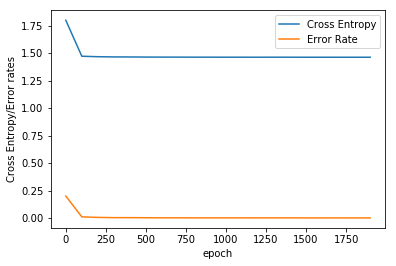

In [34]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！
# 打印输出损失值
plt.plot(np.arange(len(losses))*100,losses, label = 'Cross Entropy')
plt.plot(np.arange(len(errors))*100, np.array(errors) / float(100), label = 'Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error rates')
plt.legend()

### 第四步：在测试集上测试模型

In [39]:
#分多个batch计算测试结果
errors = []
losses = []
i = 0
for start in range(0, len(test_X), batch_size):
    end1 = start + batch_size if start + batch_size < len(test_X) else len(test_X)
    i += 1
    x = Variable(torch.FloatTensor(test_X[start:end]))
    y = Variable(torch.LongTensor(test_Y[start:end]))
    if USE_CUDA:
        net.cpu()
    predictions = net(x)
    loss = cost(predictions, y)
    err_rate = error_rate(predictions.data.numpy(), y.data.numpy())
    errors.append(err_rate)
    losses.append(loss.data.numpy())
    print(i, err_rate)

print('平均错误率：%.4f%%'%np.mean(errors))

1 2.02
2 2.35008103728
3 2.14490968801
4 1.97587354409
5 2.10792580101
6 2.13675213675
7 2.2205372617
8 2.20782073814
9 2.27272727273
10 2.09086799277
11 2.06422018349
12 1.96694599628
13 1.94943289225
14 2.07533589251
15 2.08333333333
16 1.91831683168
17 2.01207243461
18 1.9427402863
19 1.84511434511
20 1.7177589852
21 1.85483870968
22 1.80525164114
23 1.92093541203
24 1.64399092971
25 1.8331408776
26 1.83823529412
27 1.72362110312
28 1.92542787286
29 1.80798004988
30 1.87659033079
31 1.76948051948
32 1.47546419098
33 1.67682926829
34 1.24653739612
35 1.45184135977
36 1.43115942029
37 1.3909495549
38 1.32978723404
39 1.246105919
40 1.39776357827
41 1.37295081967
42 1.36784511785
43 1.27595155709
44 1.42348754448
45 1.39652014652
46 1.41509433962
47 1.41050583658
48 1.33032128514
49 1.21887966805
50 1.3143776824
51 1.5
52 1.4400921659
53 1.31578947368
54 1.05721393035
55 1.10103626943
56 1.21621621622
57 1.09463276836
58 1.03550295858
59 1.3198757764
60 1.10294117647
61 1.50862068966
6

### 用单个图像进行测试

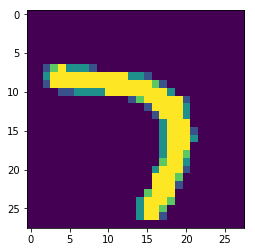

In [40]:
#随便从数据集中读入一张图片，并绘制出来
idx = 60
muteimg = test_data[idx, 0, :, :]
plt.imshow(muteimg)

In [41]:
#计算识别结果
x = Variable(torch.FloatTensor(test_X[idx, :].reshape(1, -1)))
predict = net(x)
np.argmax(predict.data.numpy())

7

## 升级版

如果你已经运行跑通上面的所有代码，那么请你尝试对其进行更改，让测试集上面的识别错误率进一步下降，看看能不能到1%以下

提示：可以考虑增加层的深度

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码